<a href="https://colab.research.google.com/github/RaphaelPetit/Transilien-SNCF-Waiting-Time-Forecasting/blob/main/Transilien_SNCF_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ideas of possible features :
#is_weekend
#num_retards_connus
#moyenne_retards_connus
#arret_normalise
#gare_freq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path1 = '/content/drive/MyDrive/Challenges Data/Transilien-SNCF/x_train_final.csv'
x_train = pd.read_csv(path1)

x_train.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

path3 = '/content/drive/MyDrive/Challenges Data/Transilien-SNCF/y_train_final_j5KGWWK.csv'
y_train = pd.read_csv(path3)

y_train.drop(columns=['Unnamed: 0'], inplace=True)

# Feature : moyenne retards connus

In [ ]:
retard_features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

x_train['moyenne_retard_connus'] = x_train[retard_features].mean(axis=1, skipna=True)

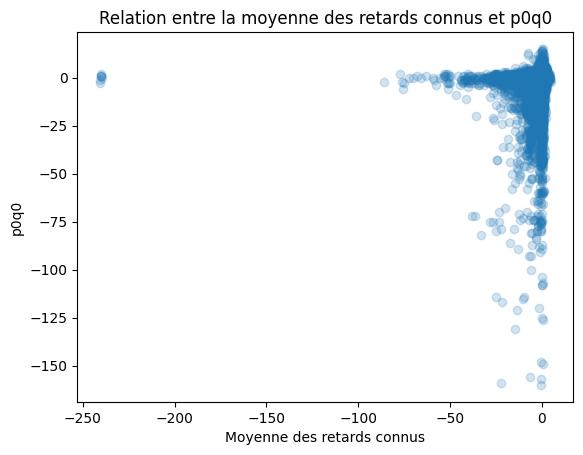

In [ ]:
plt.scatter(x_train['moyenne_retard_connus'], y_train['p0q0'],alpha=0.2)
plt.xlabel('Moyenne des retards connus')
plt.ylabel('p0q0')
plt.title('Relation entre la moyenne des retards connus et p0q0')
plt.show()

In [ ]:
from scipy.stats import pearsonr

corr, p = pearsonr(x_train['moyenne_retard_connus'].fillna(0), y_train['p0q0'])

print(f"Corrélation : {corr:.3f} - p-value : {p:.4f}")

Corrélation : 0.174 - p-value : 0.0000


# Feature : arret_normalise

In [ ]:
max_arrets = x_train.groupby('train')['arret'].max().rename('max_arret')

x_train = x_train.merge(max_arrets, on='train', how='left')

x_train['arret_normalise'] = x_train['arret']/x_train['max_arret']

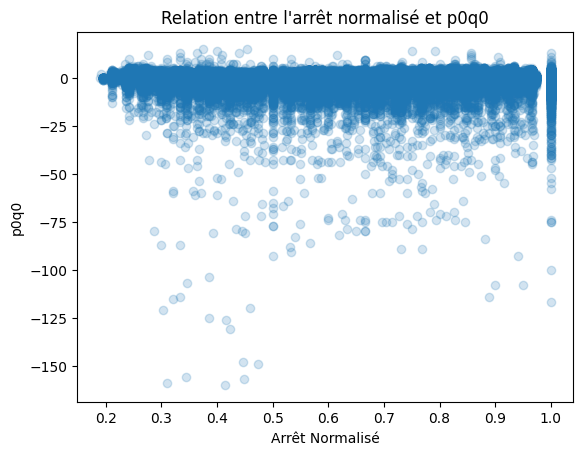

In [ ]:
plt.scatter(x_train['arret_normalise'], y_train['p0q0'],alpha=0.2)
plt.xlabel('Arrêt Normalisé')
plt.ylabel('p0q0')
plt.title("Relation entre l'arrêt normalisé et p0q0")
plt.show()

In [ ]:
from scipy.stats import pearsonr

corr, p = pearsonr(x_train['arret_normalise'].fillna(0), y_train['p0q0'])

print(f"Corrélation : {corr:.3f} - p-value : {p:.4f}")

Corrélation : 0.038 - p-value : 0.0000


# Feature : gare_freq

In [ ]:
freq_par_gare = x_train['gare'].value_counts().rename('gare_freq')

x_train = x_train.merge(freq_par_gare, left_on='gare', right_index=True)

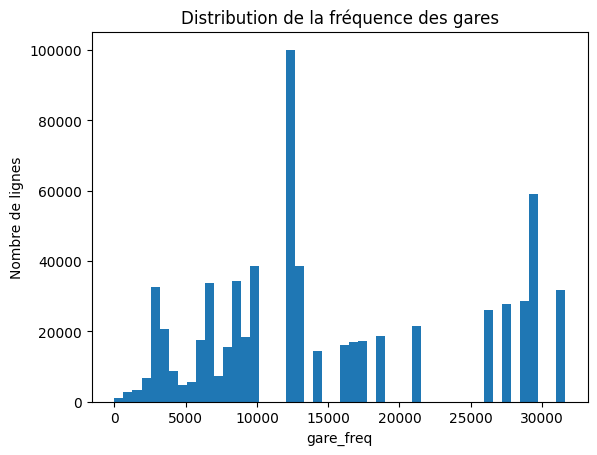

In [ ]:
plt.hist(x_train["gare_freq"], bins=50)
plt.xlabel("gare_freq")
plt.ylabel("Nombre de lignes")
plt.title("Distribution de la fréquence des gares")
plt.show()

In [ ]:
x_train['gare_freq'].describe()

,gare_freq
count,667264.000000
mean,15324.060654
std,9175.959591
min,6.000000
25%,8471.000000
50%,12579.000000
75%,26037.000000
max,31643.000000


In [ ]:
# pas de problème de skew

# Boucle de modèles

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# --- Features & Data ---
retard_feats = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
features = retard_feats + ['moyenne_retard_connus', 'arret_normalise', 'gare_freq']

# Si la feature est pas dans x_train on la calcule
if 'moyenne_retard_connus' not in x_train.columns:
  x_train['moyenne_retard_connus'] = x_train[retard_feats].mean(axis=1, skipna=True)

# Tri temporel et sampling (pour run les modeles plus vite pcq sinon imp)
sample = x_train.sample(50000, random_state=42)
x_sample = sample.sort_values('date')
y_sample = y_train.loc[x_sample.index]

X = x_sample[features].fillna(0)
y = y_sample['p0q0']

# --- TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- Modèles à tester ---
models20 = {
    "RandomForest" : RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1),
    "LightGBM" : lgb.LGBMRegressor(n_estimators=20, random_state=42),
    "XGBoost" : xgb.XGBRegressor(n_estimators=20, random_state=42, n_jobs=-1)
}

models40 = {
    "RandomForest" : RandomForestRegressor(n_estimators=40, random_state=42, n_jobs=-1),
    "LightGBM" : lgb.LGBMRegressor(n_estimators=40, random_state=42),
    "XGBoost" : xgb.XGBRegressor(n_estimators=40, random_state=42, n_jobs=-1)
}

# --- Boucle d'évaluation ---
for name, model in models20.items():
  scores = cross_val_score(model, X, y, cv=tscv, scoring=scorer)
  print(f"{name} 20 MAE (TimeSeries CV): {-scores.mean():.4f} ± {scores.std():.4f}")

for name, model in models40.items():
  scores = cross_val_score(model, X, y, cv=tscv, scoring=scorer)
  print(f"{name} 40 MAE (TimeSeries CV): {-scores.mean():.4f} ± {scores.std():.4f}")


RandomForest 20 MAE (TimeSeries CV): 0.8830 ± 0.0891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 8335, number of used features: 9
[LightGBM] [Info] Start training from score -0.080264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 16668, number of used features: 9
[LightGBM] [Info] Start training from score -0.101392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 25001, number